In [374]:

# Typical Math Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import data from mat file
import scipy.io
data = scipy.io.loadmat('Assignment4_goodness_estimators.mat')
estimators = [
    'Est1_RMS_errors',
    'Est2_RMS_errors',
    'Est3_RMS_errors',
]

# Positions from the estimators
pos = {
    'Est1': [3.2, 4.3],
    'Est2': [3.1, 4],
    'Est3': [3.3, 6],
}

# Pair the estimators with their respective positions
for key in pos.keys():
    pos[key] = {
        'x': pos[key][0],
        'y': pos[key][1],
        'w': np.array(data[f'{key}_RMS_errors']).T
    }

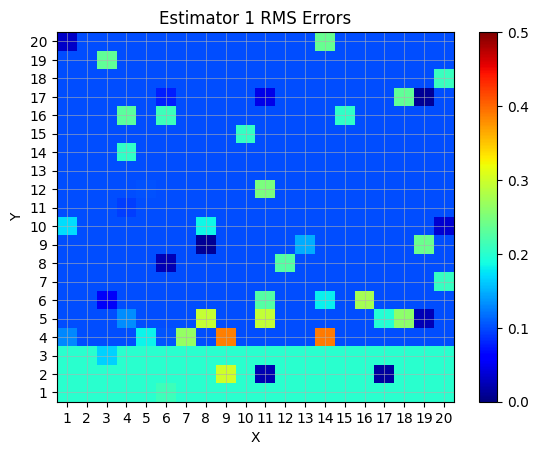

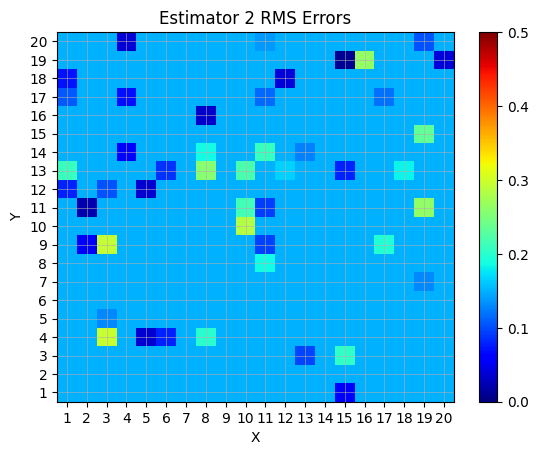

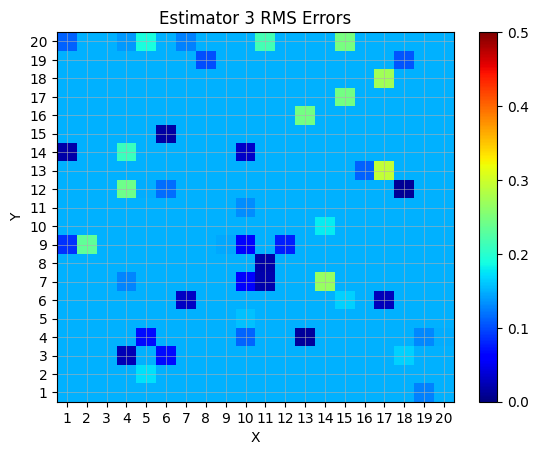

In [375]:
# Graph the 3 goodness estimators
for i, est in enumerate(estimators):
    # generate 2d grid for the x & y
    x, y = np.meshgrid(np.linspace(1, 20, 20), np.linspace(1, 20, 20))

    z = data[est]
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()

    fig, ax = plt.subplots()
    ax.pcolormesh(x, y, z, cmap='jet', vmin=0, vmax=0.5)
    ax.set_title(f'Estimator {i+1} RMS Errors')
    ax.grid(True, linewidth=0.4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.xticks(range(1, 21))
    plt.yticks(range(1, 21))
    ax.axis([0.5, 20.5, 0.5, 20.5])
    fig.colorbar(c, ax=ax)
    plt.savefig(f'out/Estimator_{i+1}_RMS_Errors.png', bbox_inches='tight')
    plt.show()


## Problem #1 - OWA Fusing Estimation
The three estimators have these estimations of (y,x) of robot position:  
- Estimator 1: (4.3, 3.2)  
- Estimator 2: (4, 3.1) 
- Estimator 3: (6, 3.3)

Let’s assume that the weights of OWA operator (for problem 1 and 2) was fixed from 
before as:  
[0.55 0.30 0.15].
 
What is the result of OWA fused estimation of y and x?  
Assume each sensor estimation separately to estimate its goodness of results (use the 
closest grid RMS).

In [376]:
# Sort the estimators by their RMS error
def get_rms(value):
    value = value[1]
    w = value['w']
    x = value['x']
    y = value['y']
    row = round(x)-1
    col = round(y)-1
    return w[row][col]

sorted_est = sorted(list(pos.items()), reverse = True, key=lambda p: get_rms(p))

# Print the order of the estimators
print('Estimator | RMS Error           | X Pos | Y Pos ')
print('----------|---------------------|-------|-------')
for est in sorted_est:
    print(f'{est[0]}      | {est[1]["w"][round(est[1]["x"])-1][round(est[1]["y"])-1] : 19} | {est[1]["x"] : 5} | {est[1]["y"] : 6}')
print()

# Combine the estimators based on the prescribed weights
weights = np.array([0.55, 0.30, 0.15])
combined = np.sum([[est[1]['x']*weight, est[1]['y']*weight] for est, weight in zip(sorted_est, weights)], 0)

# Print the fused estimate
print(f'Fused Estimate: {combined[0], combined[1]}')


Estimator | RMS Error           | X Pos | Y Pos 
----------|---------------------|-------|-------
Est2      |  0.2952191173137461 |   3.1 |      4
Est3      |                0.15 |   3.3 |      6
Est1      |                 0.1 |   3.2 |    4.3

Fused Estimate: (3.1750000000000003, 4.645)


## Problem #2 - Reweighing from Fused 
Now if with the obtained fused estimation re-evaluate the order of estimators (use the grid closest to the fused estimation to re-evaluate the order).

In [377]:
# Revaluate the weights using the RMS at the fused estimate
def get_weight(est, fused):
    est = est[1]
    w = est['w']
    x = fused[0]
    y = fused[1]
    row = round(x)-1
    col = round(y)-1
    return w[row][col]
resorted_est = sorted(list(pos.items()), reverse = True, key=lambda p: get_weight(p, combined))

# Print the order of the estimators
print('Estimator | RMS Error           | X Pos | Y Pos ')
print('----------|---------------------|-------|-------')
for est in resorted_est:
    print(f'{est[0]}      | {est[1]["w"][round(est[1]["x"])-1][round(est[1]["y"])-1] : 19} | {est[1]["x"] : 5} | {est[1]["y"] : 6}')
print()


# Recombined the estimators based on the new weights
combined = np.sum([[est[1]['x']*weight, est[1]['y']*weight] for est, weight in zip(resorted_est, weights)], 0)

# Print the fused estimate
print(f'Re-Fused Estimate: {combined[0], combined[1]}')

Estimator | RMS Error           | X Pos | Y Pos 
----------|---------------------|-------|-------
Est3      |                0.15 |   3.3 |      6
Est2      |  0.2952191173137461 |   3.1 |      4
Est1      |                 0.1 |   3.2 |    4.3

Re-Fused Estimate: (3.225, 5.145)


## Problem #3 - Orness of Weights

If we want to use new weights to have an Orness of 0.725, which set of weights provide us that (check the quiz).

Orness is represented by the function:
$$
\Omega(w) = \frac{1}{n-1} \sum_{i=1}^{n} \left( n - i \right) w_{i}
$$
When $w$ is a vector of weights, sorted greatest to least.

In [378]:
weight_sets = {
    '1': [0.65, 0.20, 0.15],
    '2': [0.60, 0.25, 0.15],
}

def get_orness(weights):
    return 1 / (len(weights)-1) * np.sum([(len(weights) - i-1)*w for i, w in enumerate(weights)])

# Attach the Orness values to the weight sets
for set in weight_sets.keys():
    weights = weight_sets[set]
    orness = get_orness(weights)
    weight_sets[set] = {
        'weights': weights,
        'orness': orness,
    }
    
# Print the weight sets
print('Orness of Weight Sets')
print(pd.DataFrame(weight_sets).T)

Orness of Weight Sets
             weights orness
1  [0.65, 0.2, 0.15]   0.75
2  [0.6, 0.25, 0.15]  0.725


## Problem #4 - Max Entropy Weights of Estimators
Find the max entropy weights for the three estimators fusion with MEOWA given the Orness level of 0.725.

The entropy of a set of weights is given by:
$$
s(w) = - \sum_{i=1}^{n} w_{i} \ln(w_{i})
$$

In [379]:
import sympy as sym
from scipy.optimize import minimize

def get_entropy(weights):
    # Set invalid weights to 0 entropy
    if any ([w < 0 for w in weights]):
        return 0.0
    # Calculate the entropy
    try:
        return -np.sum([w * np.log(w) for w in weights])
    except :
        return 0.0

# Maximize the entropy
orness_target = 0.725
res = minimize(lambda w: -get_entropy(w), [0.33, 0.33, 0.33], constraints=[
    {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] - 1},
    {'type': 'eq', 'fun': lambda w: 1/2 * (2 * w[0] + w[1]) - orness_target}
    ],
    bounds=[(0, 1), (0, 1), (0, 1)],
    tol=1e-6,
    options={'disp': False},)


print(f'Max Entropy Weights: [{res.x[0]:.4f}, {res.x[1]:.4f}, {res.x[2]:.4f}]')

Max Entropy Weights: [0.5847, 0.2806, 0.1347]
